In [2]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import matplotlib.pyplot as plt
from datasets import load_dataset
import os
from utils import prepare_prompt

# Dataset Selection

In [3]:
n_total = 5000

dataset_mlsum = load_dataset("mlsum", "fr", cache_dir="/Data/gabriel-mercier/hf_datasets")
#dataset_wiki = load_dataset("wikipedia", "20220301.fr", cache_dir="/Data/gabriel-mercier/hf_datasets")

dataset_init = dataset_mlsum['train'].shuffle(seed=42).select(range(5000)) 
dataset = dataset_init.select_columns(['text'])

In [4]:
print(dataset)
print(dataset['text'][3538])

# texts = dataset['text']
# for i in range(len(texts)):
#     t = texts[i]
#     if 'coronavirus' in t and len(t) < 6000:
#         print(t)
#         print(i)

Dataset({
    features: ['text'],
    num_rows: 5000
})
Deux personnels de santé saoudiens ont été infectés par le nouveau coronavirus proche du SRAS dont des patients hospitalisés étaient porteurs, a indiqué l'OMS mercredi. AFP/FAYEZ NURELDINE Deux personnels de santé saoudiens ont été infectés par le nouveau coronavirus proche du SRAS dont des patients hospitalisés étaient porteurs, a indiqué l'Organisation mondiale de la santé (OMS) mercredi 15 mai. "C'est la première fois qu'une infection par le nouveau coronavirus a été diagnostiquée chez des personnels de santé après un contact avec des patients", a relevé l'OMS dans un communiqué. Les deux personnels de santé infectés figurent parmi six patients porteurs du nouveau coronavirus déclarés mardi par le ministère de la santé saoudien. Si le nouvel agent infectieux a été diagnostiqué chez d'autres personnels de santé en Jordanie, il n'est pour l'instant pas prouvé qu'ils l'ont contracté auprès de patients, selon l'OMS. "C'est la premi

In [5]:
llm_name = "Qwen/Qwen2.5-32B-Instruct"
tokenizer_llm = AutoTokenizer.from_pretrained(llm_name, 
                                          cache_dir="/Data/gabriel-mercier/hf_models",
                                          padding_side='left') #auto reggressive llm

Text(0.5, 1.0, 'Distibution')

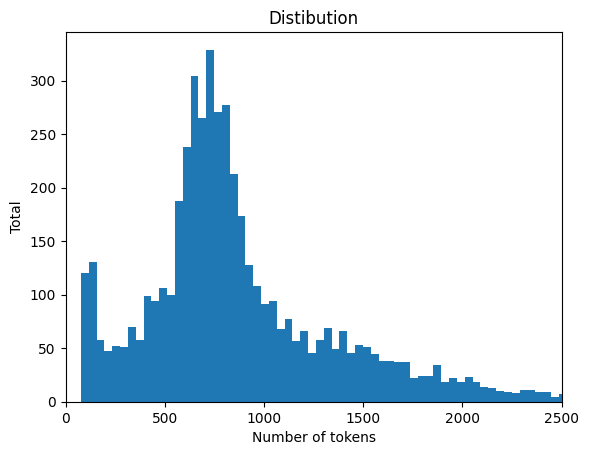

In [6]:
def get_token_length(example):
    tokens = tokenizer_llm(example["text"], truncation=True, max_length=6000)["input_ids"]
    return {"token_length": len(tokens)}

dataset_token = dataset.map(get_token_length)

plt.hist(dataset_token["token_length"], bins=150)
plt.xlim(0, 2500)
plt.xlabel("Number of tokens")
plt.ylabel("Total")
plt.title("Distibution")

In [7]:
print('average token length:', sum(dataset_token["token_length"]) / len(dataset_token["token_length"]))
print(dataset_token['token_length'][3538])


average token length: 927.0622
441


In [8]:
max_length = 2500

# Dataset Annotation

In [9]:
!nvidia-smi

Wed Mar 12 14:33:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.04             Driver Version: 570.124.04     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5000               Off |   00000000:01:00.0 Off |                  Off |
| 30%   32C    P8             20W /  230W |     149MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [11]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  
    bnb_4bit_compute_dtype=torch.float16, 
    bnb_4bit_use_double_quant=True,  
    bnb_4bit_quant_type="nf4"
)

model_llm = AutoModelForCausalLM.from_pretrained(
    llm_name,
    cache_dir="/Data/gabriel-mercier/hf_models",
    quantization_config=bnb_config, 
    device_map="auto"  
)

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
Loading checkpoint shards: 100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


In [12]:
summary_num_tokens = 250

def generate_summary(text):
    prompt = prepare_prompt({'text':text}, summary_included=False)
    inputs = tokenizer_llm(prompt, return_tensors="pt", truncation=True, max_length=max_length).to(model_llm.device)
    prompt_length = inputs.input_ids.shape[-1] 
    
    with torch.no_grad():
        output = model_llm.generate(**inputs, max_new_tokens=summary_num_tokens)
    
    generated_tokens = output[0][prompt_length:]
    summary = tokenizer_llm.decode(generated_tokens, skip_special_tokens=True)
    summary = summary.split("\n")
    summary = next((s for s in summary if s.strip()), None)
    summary_split = summary.split()
    summary = " ".join(summary_split[:125])
    return summary

In [13]:
examplesidx = [3538, 3539, 3540]
for i in examplesidx:
    data = dataset[i]
    text = data['text']
    print(text)
    summary = generate_summary(text)
    print("Summary :", summary)
    print(len(summary.split()))

Deux personnels de santé saoudiens ont été infectés par le nouveau coronavirus proche du SRAS dont des patients hospitalisés étaient porteurs, a indiqué l'OMS mercredi. AFP/FAYEZ NURELDINE Deux personnels de santé saoudiens ont été infectés par le nouveau coronavirus proche du SRAS dont des patients hospitalisés étaient porteurs, a indiqué l'Organisation mondiale de la santé (OMS) mercredi 15 mai. "C'est la première fois qu'une infection par le nouveau coronavirus a été diagnostiquée chez des personnels de santé après un contact avec des patients", a relevé l'OMS dans un communiqué. Les deux personnels de santé infectés figurent parmi six patients porteurs du nouveau coronavirus déclarés mardi par le ministère de la santé saoudien. Si le nouvel agent infectieux a été diagnostiqué chez d'autres personnels de santé en Jordanie, il n'est pour l'instant pas prouvé qu'ils l'ont contracté auprès de patients, selon l'OMS. "C'est la première fois que nous avons une preuve assez solide et rapid

In [ ]:
num_shards = 20

for i in range(num_shards):
    output_file = f"dataset_part_{i}.json"
    
    if os.path.exists(output_file):
        print(f"Le shard {i} est déjà traité, on passe au suivant.")
        continue

    shard = dataset.shard(num_shards=num_shards, index=i)
    processed_shard = shard.map(lambda x: {"summary": generate_summary(x["text"])})
    processed_shard.to_json(output_file)
    print(f"Shard {i} traité et sauvegardé dans {output_file}.")

Le shard 0 est déjà traité, on passe au suivant.
Le shard 1 est déjà traité, on passe au suivant.
Le shard 2 est déjà traité, on passe au suivant.
Le shard 3 est déjà traité, on passe au suivant.
Le shard 4 est déjà traité, on passe au suivant.
Le shard 5 est déjà traité, on passe au suivant.
Le shard 6 est déjà traité, on passe au suivant.
Le shard 7 est déjà traité, on passe au suivant.
Le shard 8 est déjà traité, on passe au suivant.
Le shard 9 est déjà traité, on passe au suivant.
Le shard 10 est déjà traité, on passe au suivant.


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Shard 11 traité et sauvegardé dans dataset_part_11.json.


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Shard 12 traité et sauvegardé dans dataset_part_12.json.


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Shard 13 traité et sauvegardé dans dataset_part_13.json.


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Shard 14 traité et sauvegardé dans dataset_part_14.json.


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Shard 15 traité et sauvegardé dans dataset_part_15.json.


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Shard 16 traité et sauvegardé dans dataset_part_16.json.


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [ ]:
import os
from datasets import load_dataset, concatenate_datasets

num_shards = 20
shard_files = []

# Récupérer la liste des fichiers existants
for i in range(num_shards):
    file_path = f"dataset_part_{i}.json"
    if os.path.exists(file_path):
        shard_files.append(file_path)
    else:
        print(f"Shard {i} introuvable.")

if not shard_files:
    print("Aucun shard trouvé.")
else:
    # Charger chaque shard dans une liste de Dataset
    datasets_list = [load_dataset("json", data_files=file_path)["train"] for file_path in shard_files]
    # Fusionner les datasets
    merged_dataset = concatenate_datasets(datasets_list)
    
    # Sauvegarder le dataset fusionné dans un nouveau fichier JSON
    merged_dataset.to_json("merged_dataset.json")
    print("Dataset fusionné et sauvegardé dans merged_dataset.json")


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Creating json from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Dataset fusionné et sauvegardé dans merged_dataset.json


In [ ]:
print(dataset)

Dataset({
    features: ['text', 'token_length', 'summary'],
    num_rows: 100
})


In [ ]:
dataset.to_json("summarization_dataset.json")


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

485812

In [ ]:
n_total = 5000

dataset_mlsum = load_dataset("mlsum", "fr", cache_dir="/Data/gabriel-mercier/hf_datasets")
#dataset_wiki = load_dataset("wikipedia", "20220301.fr", cache_dir="/Data/gabriel-mercier/hf_datasets")

dataset_init = dataset_mlsum['train'].shuffle(seed=42).select(range(5000)) 
dataset = dataset_init.select_columns(['text'])

In [ ]:
print(dataset)

Dataset({
    features: ['text'],
    num_rows: 5000
})


In [ ]:
llm_name = "Qwen/Qwen2.5-32B-Instruct"
tokenizer_llm = AutoTokenizer.from_pretrained(llm_name, 
                                          cache_dir="/Data/gabriel-mercier/hf_models",
                                          padding_side='left') #auto reggressive llm

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Text(0.5, 1.0, 'Distibution')

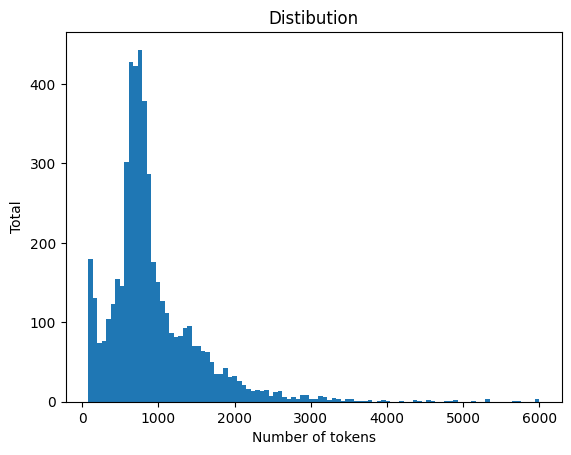

In [ ]:
def get_token_length(example):
    tokens = tokenizer_llm(example["text"], truncation=True, max_length=6000)["input_ids"]
    return {"token_length": len(tokens)}

dataset_token = dataset.map(get_token_length)

plt.hist(dataset_token["token_length"], bins=100)
plt.xlabel("Number of tokens")
plt.ylabel("Total")
plt.title("Distibution")

In [ ]:
max_length = 2500

NameError: name 'torch' is not defined